In [1]:
import matchup_calcs as mc
import tieraggregator as ta
from pokedex import Pokedex

dex = Pokedex()

I was a man on a mission. I wanted to prove that Moltres was underrated in Scarlet and Violet Overused. But how could I, a dude with a mid elo hovering in the 1400-1500 range ever properly make that argument to a higher ranked player?

A bunch of math. Because I'm a nerd. By professional training, I'm a data scientist. And I had to make sure that my method wouldn't just work for Moltres, it would have to work for *every* pokemon. And so I have learned how to definitivley quantify a pokemon's offensive and defensive weaknesses in relation to other pokemon.

Here's the basic model:

The Pokemon damage formula is pretty long, and it has the following parameters. I'm skipping the niche ones that only apply to a handful of pokemon, and the ones like level that are pretty much constant except for in a few niche cases.

1) Move power
2) Stats, using IVs and EVs
3) Weather
4) Crits
5) Random rolls
6) Burns
7) STAB
8) Type matchup

Out of these we can narrow in on a move power and stats as the only things that are really consistent from game to game because they're locked into the team builder. The dataset I got from the pokemon showdown API at https://play.pokemonshowdown.com/data/pokedex.json didn't contain movesets, so we're not counting those either.

What we're left with are the two things that basically every team is built around: a pokemon's typing and stats. But different pokemon have different matchups based on those types and stats! Blissey is very good at walling most special attackers, but is very weak into a physical fighting type. So we need our model to focus on individual offensive and defensive matchups. Step one of the model is figuring out how to generate metrics for two pokemon in a 1v1 scenario. 

Here's the basic formula:

 *1v1 score = type_matchup * attacker stat * faster? / defender stat / (defender hp/86.2)*

This formula gets you a score to measure the expected damage multiplier of the attacker vs the defender based on stats and typing, and then adjusts the survivability of the defender by their hp stat. A lower defensive score is better because it means in this matchup, the pokemon is expected to take less damage. A higher offensive score is better because it means that in this matchup, the pokemon is expected to deal more damage.

In [2]:
#Here are a few example matchups from the OU tier to help you understand how the scores work and what normal scores look like.

print('Great Tusk fighting Gholdengo')
print(mc.score_1v1_names('greattusk', 'gholdengo'))
print('Raging Bolt fighting Clodsire')
print(mc.score_1v1_names('ragingbolt', 'clodsire'))
print('Skarmory fighting Clefable')
print(mc.score_1v1_names('skarmory', 'clefable'))

Great Tusk fighting Gholdengo
{'Offense': 1.78, 'Defense': 1.88}
Raging Bolt fighting Clodsire
{'Offense': 0.59, 'Defense': 0.85}
Skarmory fighting Clefable
{'Offense': 1.94, 'Defense': 0.9}


Type matchup is the expected damage multiplier dealt based on the type matchup between the two pokemon. To make things easier, we're assuming that a pokemon is using a move of its type since I can't account for coverage moves easily. If the attacker is monotype this is pretty easy, but if there are dual types involved we average the expected outcomes. For example, if a Great Tusk [Ground, Fighting] is attacking a Gholdengo [Ghost, Steel], then the expected type score will be:

Ground -> [Ghost, Steel] = 2x
Fighting -> [Ghost, Steel] = 0x

[2 + 0] / 2 = 1, so we expect a type score of 1.

Then the attacker stat is the attacker's highest attacking stat, and the defender stat is the defensive stat that the defender is using to take the hit. In the actual damage formula the base damage of an attack is (Base Power)*(attacker stat/defender stat), so this part is ripped straight from the damage formula. In the above example, the attacker stat would be attack because Great Tusk is a physical attacker, and the defender stat is Gholdengo's physical defense. In the edge case where a pokemon's attack and special attack are exactly equal (like Kyurem), we calculate two seperate offense scores, one physical and one special, and then average the two final scores. I spent like an hour trying to figure out if Kyurem was stronger than Calyrex Ice because this edge case was a little annoying to figure out a formula for.

Faster? is the term I added to try to adjust for the speed stat of a pokemon in the offense score. It toggles on and multiplies the offense multiplier by 1.3 in a matchup where the attacking pokemon is faster, otherwise it does nothing. This is important because pokemon like kingambit and weavile have similar offensive profiles but are on completely opposite sides of the speed spectrum. Because my model can't account for things like priority moves and abilities (which I will talk about later), kingambit should have a noticeable lower offense score than Weavile, but not by too much. 1.3 ended up being a good compromise number to adjust for these types of discrepancies.

The last part of the 1v1 score is to adjust for the defender's HP stat. We divide the overall score by HP/86.2 because 86.2 is the average HP stat for all competitivley viable pokemon in gen 9 (meaning any pokemon in a tier PU or above, but not counting Ubers). Here are a couple of examples of why this is important. Ting-Lu is really bulky with an HP stat of 130, so we need to lower its defense score to show it can take more damage than an average pokemon. 130/86.2 = 1.5, so we divide by 1.5 to lower the defense score. That's the same as reducing the defense score by 33%.  A pokemon like Deoxys-speed has a super low HP stat of 50, so we need to increase its defense score to show that it can take less damage than average. 50/86.2 = 0.58 and when you divide by a fraction, numbers get bigger. Dividing by 0.58 is the same as raising the defense score by 72%. Before I added in the HP stat modification, walls like Clodsire and Alomoloa with high HP but lower defenses would stick out as looking much less bulky than they actually are.



The next step is to show how pokemon generally match up against the rest of a tier. Doing this is pretty easy: you put the pokemon into a 1v1 matchup with every pokemon of a given tier and then average the scores you get. If a pokemon is evenly matched into a tier, its scores should generally between be 1 between and 2 for both scores against anything else in the tier. It's also normal for many pokemon to have similar looking scores for both, for example a wall having scores of 0.8 and a fast but frail pokemon having scores of 1.8.

In [3]:
#More Examples of things with varying power levels

#Kingambit has good offenses and is pretty bulky. It fits OU pretty well.
print('Kingambit vs the OU tier')
print(mc.poke_vs_tier('kingambit', 'OU'))

#Volcarona has high offenses but it's balanced out by some issues switching in. It fits OU pretty well.
print('Volcarona vs the OU tier')
print(mc.poke_vs_tier('volcarona', 'OU'))

#Kyogre has very high offenses even before rain and it's really bulky. It's banned for a reason!
print('Kyogre vs the OU tier')
print(mc.poke_vs_tier('kyogre', 'OU'))

#Frosmoth has good offenses but it can't switch into most OU pokemon. It's in PU for a reason.
print('Frosmoth vs OU')
print(mc.poke_vs_tier('frosmoth', 'OU'))

Kingambit vs the OU tier
{'Pokemon_Name': 'kingambit', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.15, 'Avg_Offense': 1.61}
Volcarona vs the OU tier
{'Pokemon_Name': 'volcarona', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.9, 'Avg_Offense': 1.88}
Kyogre vs the OU tier
{'Pokemon_Name': 'kyogre', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.03, 'Avg_Offense': 2.22}
Frosmoth vs OU
{'Pokemon_Name': 'frosmoth', 'Tier_Compared_To': 'OU', 'Avg_Defense': 3.5, 'Avg_Offense': 1.78}


Now let's take a look at graphs and averages!

A quick stats lesson: The average is the expected value for any random pokemon that you would pick out of a hat. It's supposed to be a pretty good guess.

A histogram is a graph that works likes this:
1) You split a number line into buckets 
2) You have a list of things, in this case that pokemon, that each have a numerical score of some kind. You make a bar chart that measures how many pokemon fall into each bucket. Tall bar means a lot of pokemon live in that number zone, short bar means a few pokemon live in that number zone. Uusally histograms will make a shape like a bell or a hill where it's really tall in the middle and flattens out at the sides, because most things will look like the average value.

In [4]:
#This prints out the average scores for each pokemon fighting all of the fellow members of its tiers.
for tier in ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']:
    print(tier, ta.tier_avg(tier))

#The Average scores are identical because the Defense and Offense scores are tierwide perfect mirrors of each other.

Uber {'Avg_Defense': 1.82, 'Avg_Offense': 1.82}
OU {'Avg_Defense': 1.61, 'Avg_Offense': 1.61}
UU {'Avg_Defense': 1.61, 'Avg_Offense': 1.61}
RU {'Avg_Defense': 1.71, 'Avg_Offense': 1.71}
NU {'Avg_Defense': 1.71, 'Avg_Offense': 1.71}
PU {'Avg_Defense': 1.77, 'Avg_Offense': 1.77}
ZU {'Avg_Defense': 2.09, 'Avg_Offense': 2.09}


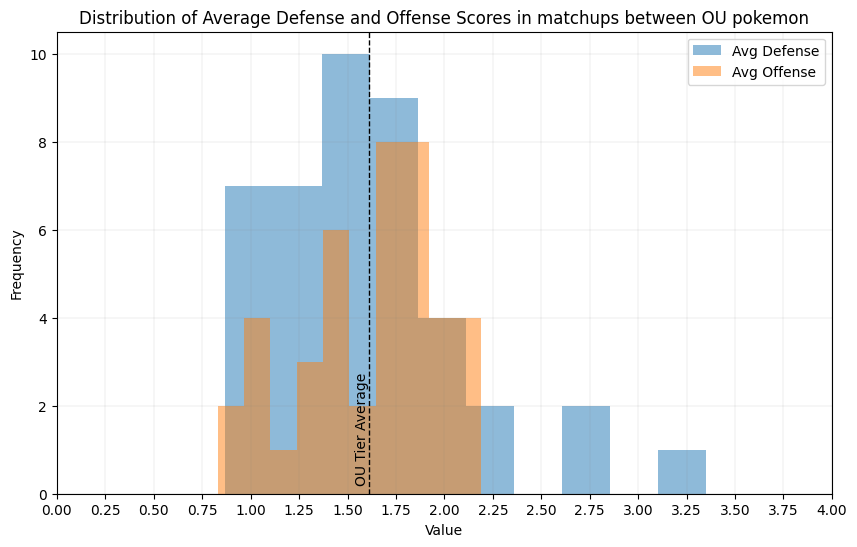

In [5]:
ou_matchups = ta.tier_vs_tier('OU', 'OU')

import matplotlib.pyplot as plt
import numpy as np

# Extract Avg_Defense and Avg_Offense values from ou_matchups
avg_defense_ou = [matchup['Avg_Defense'] for matchup in ou_matchups]
avg_offense_ou = [matchup['Avg_Offense'] for matchup in ou_matchups]

# Plotting
plt.figure(figsize=(10, 6))

# Histogram for Avg_Defense
plt.hist(avg_defense_ou, bins = 10, alpha=0.5, label='Avg Defense')

# Histogram for Avg_Offense
plt.hist(avg_offense_ou, bins = 10, alpha=0.5, label='Avg Offense')

plt.title('Distribution of Average Defense and Offense Scores in matchups between OU pokemon')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

#changing tick marks
min_value = min(min(avg_defense_ou), min(avg_offense_ou))
max_value = max(max(avg_defense_ou), max(avg_offense_ou))
plt.xticks(np.arange(np.floor(min_value), np.ceil(max_value) + 0.25, 0.25))

# Enhancing grid visibility
plt.grid(True, linewidth=0.1, color='grey')

#Tier average line
plt.axvline(x=1.61, color='black', linestyle='--', linewidth=1)
plt.text(1.61, plt.ylim()[1] * 0.025, 'OU Tier Average', rotation=90, color='black', horizontalalignment='right')

plt.show()


As you can see here: Most OU pokemon have a higher offense score and a lower defense score than the tier average. That means the pokemon in OU on average deal solid damage and can switch into other pokemon in the tier. You'll have a few edge cases for monotype pokemon with very uneven stat spreads, like Blissey or Barraskewda.

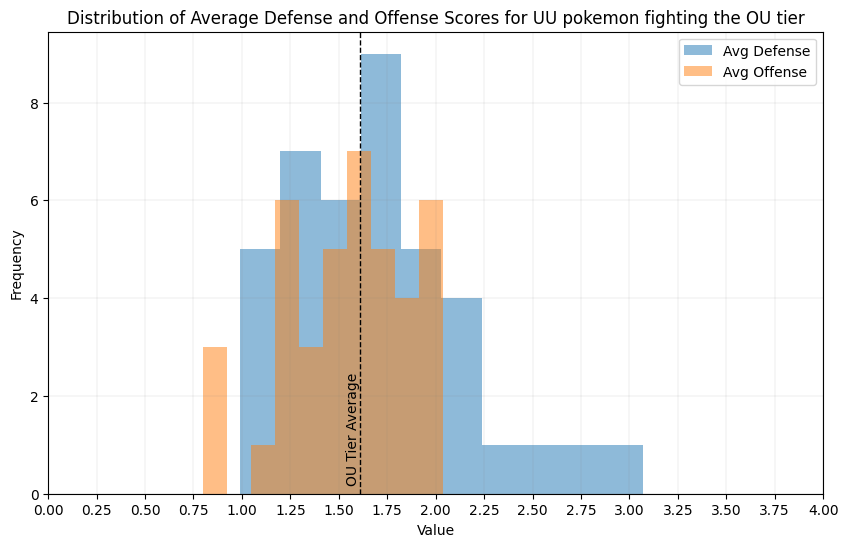

In [6]:
uu_matchups = ta.tier_vs_tier('UU', 'OU')

# Extract Avg_Defense and Avg_Offense values from ou_matchups
avg_defense_uu = [matchup['Avg_Defense'] for matchup in uu_matchups]
avg_offense_uu = [matchup['Avg_Offense'] for matchup in uu_matchups]

# Plotting
plt.figure(figsize=(10, 6))

# Histogram for Avg_Defense
plt.hist(avg_defense_uu, alpha=0.5, label='Avg Defense')

# Histogram for Avg_Offense
plt.hist(avg_offense_uu, alpha=0.5, label='Avg Offense')

plt.title('Distribution of Average Defense and Offense Scores for UU pokemon fighting the OU tier')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

#changing tick marks
min_value = min(min(avg_defense_uu), min(avg_offense_uu))
max_value = max(max(avg_defense_uu), max(avg_offense_uu))
plt.xticks(np.arange(np.floor(min_value), np.ceil(max_value) + 0.25, 0.25))

#Tier average line
plt.axvline(x=1.61, color='black', linestyle='--', linewidth=1)
plt.text(1.61, plt.ylim()[1] * 0.025, 'OU Tier Average', rotation=90, color='black', horizontalalignment='right')

# Enhancing grid visibility
plt.grid(True, linewidth=0.1, color='grey')

plt.show()

But if you take the UU pokemon and see how they stack up on average into OU threats, you can see numerically that they have a harder time. UU pokemon fighting the OU tier have offense scores on average that are a little lower than an OU pokemon fighting the OU tier, while the UU pokemon fighting OU pokemon have defense scores on average that are a little higher that OU pokemon fighting OU pokemon. But many individual UU pokemon still have good stats and typings for favorable matchups into the OU tier. The average UU pokemon's stats and typings make switching in and dealing damage a little harder in OU, but most of these pokemon are still useable in OU in the right niches.

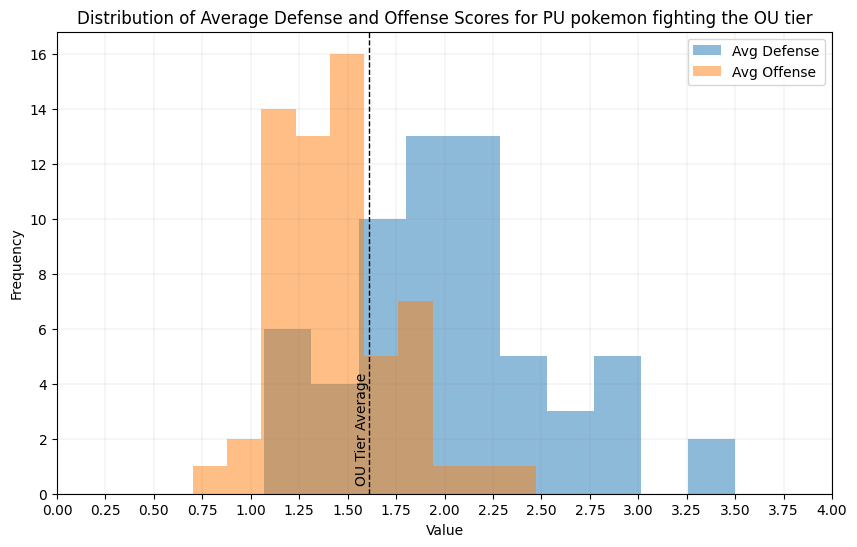

In [7]:
pu_matchups = ta.tier_vs_tier('PU', 'OU')

# Extract Avg_Defense and Avg_Offense values from ou_matchups
avg_defense_pu = [matchup['Avg_Defense'] for matchup in pu_matchups]
avg_offense_pu = [matchup['Avg_Offense'] for matchup in pu_matchups]

# Plotting
plt.figure(figsize=(10, 6))

# Histogram for Avg_Defense
plt.hist(avg_defense_pu, alpha=0.5, label='Avg Defense')

# Histogram for Avg_Offense
plt.hist(avg_offense_pu, alpha=0.5, label='Avg Offense')

plt.title('Distribution of Average Defense and Offense Scores for PU pokemon fighting the OU tier')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

#changing tick marks
min_value = min(min(avg_defense_pu), min(avg_offense_pu))
max_value = max(max(avg_defense_pu), max(avg_offense_pu))
plt.xticks(np.arange(np.floor(min_value), np.ceil(max_value) + 0.25, 0.25))

# Enhancing grid visibility
plt.grid(True, linewidth=0.1, color='grey')

#Tier average line
plt.axvline(x=1.61, color='black', linestyle='--', linewidth=1)
plt.text(1.61, plt.ylim()[1] * 0.025, 'OU Tier Average', rotation=90, color='black', horizontalalignment='right')

plt.show()

And we can see that most PU pokemon match up really badly into the OU tier, because their scores in the tier are very bad. Their offense scores are nearly all below the OU tier average, and every pokemon in PU has a defense score above the tier average! Expecting to deal low damage and expecting to take high damage is is the exact opposite of how an effective pokemon should look, and so PU pokemon are PU for a reason.

And now for arguments about a few individual pokemon.

This entire data science project was originally about Moltres. I think it's a good pokemon in gen 9 OU. It has good bulk, a good typing both offensivley and defensivley, and it matches up well into Kingambit, Great Tusk, Iron Valiant, Gholdengo, Rillaboom, Volcarona, and Skarmory. This is an insane matchup list! And, on top of all that, Moltres has great defensive and offensive synergy with Kingambit and Great Tusk. These three pokemon together are only weak to the water type and have immunities to electric, ground, and psychic type moves... their defensive role compression is amazing! Just Moltres, Kingabmit, and any grass/dragon type is enough to have a viable switch in to the entire type chart! Moltres also has a lot of set flexibility: it's a great burn spreader with flame body, willow wisp, and scorching sands while also having u-turn, roost, roar, and the great offensive combination of flying+fire STAB as well as ground+rock coverage. It's a highly customizeable bulky pivot pokemon for offense teams that partners extremely well with the best pokemon in the OU tier! Idk what this thing is doing in RU.

Can I numerically prove that Moltres is good in OU? Yes. Moltres, in terms of stats and typing, Moltres performs very well in OU with a defense score of 1.35 and an offense score of 1.82. It's more offensivley threatening than the average pokemon in the tier while also being pretty bulky. It's got the bulk and offensive presence of pokemon like Heatran, Raging Bolt, and Gholdengo while having U-turn and a recovery move! #FreeMoltres

In [8]:
print(mc.poke_vs_tier("moltres", "OU"))
print(mc.poke_vs_tier("heatran", "OU"))
print(mc.poke_vs_tier("ragingbolt", "OU"))
print(mc.poke_vs_tier("gholdengo", "OU"))

{'Pokemon_Name': 'moltres', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.35, 'Avg_Offense': 1.82}
{'Pokemon_Name': 'heatran', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.3, 'Avg_Offense': 1.7}
{'Pokemon_Name': 'ragingbolt', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.11, 'Avg_Offense': 1.88}
{'Pokemon_Name': 'gholdengo', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.35, 'Avg_Offense': 1.76}


Another pokemon I'd like to bring up is Keldeo. Keldeo is a good pokemon and literally everyone knows that. But in past generations because of the presence of universal walls like Toxapex, mixed with fierce competition from Urshifu Rapid, Keldo has had a hard time seeing usage in OU. But now Keldeo has vaccum wave, urshifu is gone, toxapex sucks, and Clodsire mostly sees use on stall. I think that Keldeo is still being overlooked because of generatoin 7 and 8.

Keldeo faces good competition from Walking Wake and Ogerpon-Wellspring for the speedy offensive water type slot on a team, but Keldeo has enough distinct advantages to stand out and have a great niche in OU. Its fighting type, access to a good boosting move in calm mind, and unique access to a strong special attacking priority move give Keldeo a niche that no other pokemon can fill, and Keldeo will feel very at home on many OU teams. 

Numerically, Keldeo has good defenses for the tier at a score of 1.38 and a stellar Offense score of 2.04, Keldeo needs to see more usage. It makes fantastic use of choice items while still having the flexibility to run a calm mind sweeper set.

In [9]:
print(mc.poke_vs_tier("keldeo", "OU"))
print(mc.poke_vs_tier("walkingwake", "OU"))
print(mc.poke_vs_tier("ogerponwellspring", "OU"))

{'Pokemon_Name': 'keldeo', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.38, 'Avg_Offense': 2.04}
{'Pokemon_Name': 'walkingwake', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.22, 'Avg_Offense': 1.81}
{'Pokemon_Name': 'ogerponwellspring', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.46, 'Avg_Offense': 1.67}


I really want to see people who are better at team building than me make offense teams with a fire water grass/dragon core of something like Moltres, Keldeo, and Rillaboom or Moltres, Keldeo, and Raging Bolt. 

Here's a silly sample team https://pokepast.es/b01ea7d1d8964331 with Moltres and Keldeo that got me to 1500 elo pretty easily. A much more standard OU team with the Moltres-Tusk-Gambit core https://pokepast.es/6a15e0ce0de3f6a0 like this or this https://pokepast.es/c796ee371f73a346 (the only diff between these two sample teams is glowking vs hattrene) should ladder very well. 

Moltres + Kingambit + A ground type + A water type + A dragon/grass type + some hazards and hazard removal is a very strong and customizeable template for an offense team, especially in the current meta where you have lots of pokemon who compress some of these roles together.

The last topic I want to cover is abilities and moves. What I've learned from this project is that yes, stats and type matchups matter a lot in how tiers are organized. But abilities and moves are what actually break a pokemon.

For example:

In [10]:
print('Ice types vs Ubers')
print(mc.poke_vs_tier('kyurem', 'Uber'))
print(mc.poke_vs_tier('baxcalibur', 'Uber'))
print(mc.poke_vs_tier('calyrexice', 'Uber'))
print('Ice types vs OU')
print(mc.poke_vs_tier('kyurem', 'OU'))
print(mc.poke_vs_tier('baxcalibur', 'OU'))
print(mc.poke_vs_tier('calyrexice', 'OU'))

Ice types vs Ubers
{'Pokemon_Name': 'kyurem', 'Tier_Compared_To': 'Uber', 'Avg_Defense': 1.54, 'Avg_Offense': 1.84}
{'Pokemon_Name': 'baxcalibur', 'Tier_Compared_To': 'Uber', 'Avg_Defense': 1.83, 'Avg_Offense': 1.93}
{'Pokemon_Name': 'calyrexice', 'Tier_Compared_To': 'Uber', 'Avg_Defense': 1.21, 'Avg_Offense': 1.98}
Ice types vs OU
{'Pokemon_Name': 'kyurem', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.2, 'Avg_Offense': 1.95}
{'Pokemon_Name': 'baxcalibur', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.35, 'Avg_Offense': 2.09}
{'Pokemon_Name': 'calyrexice', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.13, 'Avg_Offense': 2.11}


Kyurem, Baxcalibur, and Calyrex Ice have pretty similar typings and matchup scores into the Ubers and OU tiers. But Calyrex-Ice and Baxcalibur were banned, and Kyurem wasn't. This comes down to their abilities and move pools.

Kyruem feels hard to deal with in OU because it has amazing coverage options, good stats, and set diversity. It can be a physical sweeper, a special wall breaker, and a defensive nuissance pp stalling nuisance. But Kyurem is still ok in gen 9 OU because, in the modern day, what really pushes a pokemon over the edge is a special bullshit factor that either removes important counterplay or gives them special treatment in the damage calculator. 

Baxcalibur has thermal exchange and very high base power moves, so you can't counter it by burning it. It also gets to set up for free just by switching into fire moves, and it still has the option to set up manually and kill everything. On top of all of that Baxcalibur has the option to pick a priority move to stop revenge killers or to pick coverage to muscle through basically any pokemon in the game.

Calyrex-Ice has trick room, boosts its attack on every kill, has a 120 base power STAB move with perfect accuracy, and has perfect coverage with just two moves. You can't revenge kill it with a faster pokemon and it doesn't even need to set up to sweep your whole team even in front of pokemon that should be able to wall it. Kyurem has great traits and is very annoying, but it's fundamentally a very honest pokemon compared to these two poop stains. 

Set up and priority moves get pokemon banned very often because these moves are the easiest way to remove counterplay from a pokemon. Priority moves on a sweeper remove the option to revenge kill the sweeper, and set up moves remove options like switching in safely to the sweeper or outspeeding the sweeper. Modern day OU is full of pokemon with these options, and you need to have an amazing defensive profile and/or defensive abilities like unaware to compete defensivley in this environment. A pokemon that would normally be in UU or RU or even PU can magically leap up to OU if it's given a bullshit factor. This is why modern starters keep getting broken stuff like the grassy surge + grassy glide combo, or protean and libero. This is why pokemon like Quagsire and Clefable stay eternally relevant in OU even though they really shouldn't be able to, because a good typing and abilities like magic guard and unaware give them a special defensive bullshit factor.

To sum this section up:

Ok stats - Bullshit = Low tier pokemon
Ok stats + Bullshit = high tier pokemon
Good stats - Bullshit = high tier pokemon
Good stats + Bullshit = overpowered pokemon

But, on average, good pokemon have good stats and typing. The bullshit factor can only do so much.

And now we use this combination of stuff to make a teambuilder that can tell you in advance if your team sucks. One that lets the noobs know what is good and what is bad without needing an expert on hand. And one that lets experienced team builders quickly find hidden gem pokemon in lower tiers that are much more viable than expected.

So how do we that, with all of the stats I just did?

A good, well balanced team in any tier should have the following traits:

-It should have a resistance or immunity to every type
-It should be able to hit every type for neutral STAB damage
-The average offense and defense scores for the team should be similar to the tier average. Offensive teams should have a higher average offense score than the tier average and be ok with a higher average defense score than the tier average, while a more defensive team should make the opposite tradeoff of a lower average defense score and a lower average offense score.

A smart teambuilder can tell you all of this stuff! Luckily I just did all of the work necessary to build one, so... here's a smart team builder. I'm going to include a link to a publicly accessible way to run this in the github!

In [5]:
import teamchecker as tc

#If you spell any of the names you type in wrong the program will throw errors. Double check your spelling! I'm using this sample team https://pokepast.es/c796ee371f73a346 as an example input.

#Fill in your pokemon names here. For pokemon with spaces or dashes in their name, type in the name as one word, e.g. Great Tusk becomes greattusk and Arceus-Fire becomes arceusfire. Names here are not case sensitive, and you can test a team of fewer than 6 pokemon if you want.
pokemon = ['moltres', 'kingambit', 'greattusk', 'samurotthisui', 'kyurem', 'slowkinggalar']

#Make sure the tier is capitalized correctly! If you are building a team for Ubers, the tier should be "Uber". The team scores portion of the team builder aren't built for doubles, but you can still use this as a type checker for doubles.
tier = 'OU'

#Run the team builder! It will give you feedback based on your team.
tc.teamcheck(tier, pokemon)

Your Team Offense:1.76 
OU Average Offense: 1.61
Your team deals 9.000000000000014% more damage than average. 

Your team is above average offensivley!

Your Team Defense:1.52 
OU Average Defense: 1.61
Your team takes 6.0% less damage than average.

Your team is above average defensivley!

You can hit every type for neutral or super effective damage!
You can switch into and safely resist any type!

Your team is prepared for any type matchup,
and your pokemon match up well both offensivley and defensivley into the tier.
Congratulations, your tream is very well rounded!
